# Pytorch final project Cat face landmark detection


In [1]:
import os, torch, torchvision, random
import pandas as pd
import numpy as np
import torch.nn as nn
import matplotlib.pyplot as plt
from PIL import Image

import cv2

import torch.nn.functional as F
import torchvision.transforms as transforms
import torchvision.models as models
from torch.utils.data import Dataset, random_split, DataLoader
from torchvision.datasets import ImageFolder
from torchvision import models
from torch import optim
from torchsummary import summary

In [2]:
torch.cuda.is_available()

True

In [3]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

### Part 1：Dataloader 實作

In [4]:
# 1.1. 填入 ??? 的部份

class CatDataset(Dataset):
    
    def __init__(self, images, labels, transform):
        
        self.imgs = images
        self.labels = labels
        self.transform = transform
        
    def __len__(self):
        
        return len(self.imgs) # return DataSet 長度
 
    def __getitem__(self, idx):

        image = self.imgs[idx]
        image = image[...,::-1].copy()
        image = self.transform(image)
        label = np.array(self.labels[idx])
            
        return image, label # return 模型訓練所需的資訊


In [5]:
normalize = transforms.Normalize(mean = [0.485, 0.456, 0.406], std = [0.229, 0.224, 0.225])

# Transformer
train_transformer = transforms.Compose([
    #transforms.Resize(224),
    #transforms.RandomResizedCrop(224),
    #transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    normalize
])
 
test_transformer = transforms.Compose([
    #transforms.Resize(224),
    #transforms.CenterCrop(224),
    transforms.ToTensor(),
    normalize
])

# 1.2. 填入 ??? 的部份
# datas is a list with a lot of data [cat_00,cat_01,...]
def split_Train_Val_Data(datas):
    
    data = []
    for d in datas:
        imgs = d.item().get('imgs')
        lmks = d.item().get('lmks')
        for i in range(len(imgs)):
            data.append([imgs[i],lmks[i]])
    train_inputs, test_inputs = [], []
    train_labels, test_labels = [], []

    num_sample_train = int(len(data)*0.9)
    num_sample_test = len(data)-num_sample_train

    print(str(len(data)) + ' | ' + str(num_sample_train) + ' | ' + str(num_sample_test))

    for x in data[0:num_sample_train] : # 前 80% 資料存進 training list
        train_inputs.append(x[0])
        train_labels.append(x[1])

    for x in data[num_sample_train:len(data)] : # 後 20% 資料存進 testing list
        test_inputs.append(x[0])
        test_labels.append(x[1])
            
#     for i in range(5):
#         print(train_inputs[i],train_labels[i])
    train_dataloader = DataLoader(CatDataset(train_inputs,train_labels,train_transformer),
                                  batch_size = batch_size, shuffle = True)
    test_dataloader = DataLoader(CatDataset(test_inputs,test_labels,test_transformer),
                                  batch_size = batch_size, shuffle = False)
 
    return train_dataloader, test_dataloader

### Part 2: 建立 CNN Model

In [6]:
class PytorchModule(nn.Module):

    def __init__(self):
        super(PytorchModule,self).__init__()
        v = torch.hub.load('pytorch/vision:v0.6.0', 'mobilenet_v2', pretrained=True)
        v.classifier[1] = nn.Linear(v.last_channel, 18)
#         v = torch.hub.load('pytorch/vision:v0.6.0', 'resnext50_32x4d',pretrained=False)
#         v.fc = nn.Linear(2048, 4)
        self.layer1 = v
               
    def forward(self, x):
        out = self.layer1(x)
        return out

In [7]:
class RMSELoss(nn.Module):
    def __init__(self):
        super().__init__()
        self.mse = nn.MSELoss()
        
    def forward(self,predice,label):
        return torch.sqrt(self.mse(predice,label))

In [8]:
def distence(x1,y1,x2,y2):
    return (x1-x2)**2 + (y1-y2)**2

### Setting

依據需求調整參數

In [19]:
batch_size = 64
lr = 1e-3
epochs = 100


In [ ]:
datas = []
dataset_name =["../dataset/lmks_CAT_00.npy","../dataset/lmks_CAT_01.npy","../dataset/lmks_CAT_02.npy",
               "../dataset/lmks_CAT_03.npy","../dataset/lmks_CAT_04.npy","../dataset/lmks_CAT_05.npy"]
for name in dataset_name:
    data = np.load(name,allow_pickle=True)
    datas.append(data)

In [21]:
# 2.3. 
train_dataloader, test_dataloader = split_Train_Val_Data(datas)

C = PytorchModule().to(device)  # 使用內建的 model 或是自行設計的 model
optimizer_C = optim.Adam(C.parameters(), lr = lr) # 選擇你想用的 optimizer
#print(C)
summary(C, (3, 224, 224)) # 利用 torchsummary 的 summary package 印出模型資訊，input size: (3 * 224 * 224)

# Loss function
criterion = RMSELoss() # 選擇想用的 loss function

8609 | 7748 | 861
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 32, 112, 112]             864
       BatchNorm2d-2         [-1, 32, 112, 112]              64
             ReLU6-3         [-1, 32, 112, 112]               0
            Conv2d-4         [-1, 32, 112, 112]             288
       BatchNorm2d-5         [-1, 32, 112, 112]              64
             ReLU6-6         [-1, 32, 112, 112]               0
            Conv2d-7         [-1, 16, 112, 112]             512
       BatchNorm2d-8         [-1, 16, 112, 112]              32
  InvertedResidual-9         [-1, 16, 112, 112]               0
           Conv2d-10         [-1, 96, 112, 112]           1,536
      BatchNorm2d-11         [-1, 96, 112, 112]             192
            ReLU6-12         [-1, 96, 112, 112]               0
           Conv2d-13           [-1, 96, 56, 56]             864
      BatchNorm2d-14 

Using cache found in C:\Users\kaoti/.cache\torch\hub\pytorch_vision_v0.6.0


In [22]:
loss_epoch_C = []
train_acc, test_acc = [], []
train_delta, test_delta = [], []
best_acc, best_auc = 0.0, 0.0
for i in range(9):
    train_acc.append([])
    test_acc.append([])

### 3. 實作模型訓練和測試模型效能

In [23]:
%%time

radius2 = 36
store_name = "mobilenet_RMSELoss100_36"

if __name__ == '__main__':    
    
    for epoch in range(epochs):
    
        iter = 0
        total_train = 0
        total_test = 0
        corrects_train = []
        corrects_test = []
        for i in range(9):
            corrects_train.append(0)
            corrects_test.append(0)
        train_loss_C = 0.0

        C.train() # 設定 train 或 eval
      
        print('epoch:%4d' %(epoch + 1) + ' / ' + str(epochs) ,end = " ")  
        
        # ---------------------------
        # Training Stage
        # ---------------------------
        
        for i, (x, label) in enumerate(train_dataloader) :
                     
            x, label = x.to(device), label.to(device)
            
            optimizer_C.zero_grad() # 清空梯度
            
            output = C(x) # 將訓練資料輸入至模型進行訓練
            #print(output,label.long())
            loss = criterion(output,label.float()) # 計算 loss
            
            loss.backward() # 將 loss 反向傳播
            optimizer_C.step() # 更新權重
            
            # 計算訓練資料的準確度 (correct_train / total_train)
            predicted = output.data
            total_train += len(label)
            # if the distence of the left predicted point to the real point is samller than 5, correct++
            for i in range(len(predicted)):
                for j in range(len(corrects_train)):
                    if(distence(predicted[i][j*2],predicted[i][j*2+1],label[i][j*2],label[i][j*2+1]) < radius2):
                        corrects_train[j] += 1
            train_loss_C += loss.item()
            iter += 1
                    
        print('Training epoch:%4d / loss_C: %4.3f | acc_0: %.3f | acc_1 %.3f |' % \
              (epoch + 1, train_loss_C / iter, corrects_train[0] / total_train, corrects_train[1]/total_train ) ,end = " ")

        
        # --------------------------
        # Testing Stage
        # --------------------------
        
        C.eval() # 設定 train 或 eval
          
        for i, (x, label) in enumerate(test_dataloader) :
          
            with torch.no_grad(): # 測試階段不需要求梯度
                x, label = x.to(device), label.to(device)
                
                output = C(x) # 將測試資料輸入至模型進行測試
                loss = criterion(output, label.long()) # 計算測試資料的準確度
                predicted = output.data
                total_test += len(label)
                for i in range(len(predicted)):
                    for j in range(len(corrects_test)):
                        if(distence(predicted[i][j*2],predicted[i][j*2+1],label[i][j*2],label[i][j*2+1]) < radius2):
                            corrects_test[j] += 1
                #correct_test += (predicted == label).int().sum()
        
        print('Testing acc: [0] %.3f , [1] %.3f' % (corrects_test[0] / total_test, corrects_test[1] / total_test))
                       
        for i in range(9):
            train_acc[i].append(100 * (corrects_train[i] / total_train))
            test_acc[i].append(100 * (corrects_test[i] / total_test))
        loss_epoch_C.append(loss.data) # loss 
        
        
    #save the model variable to .ph file
    torch.save(C.state_dict(), store_name + ".ph")
    

epoch:   1 / 100 Training epoch:   1 / loss_C: 75.086 | acc_0: 0.002 | acc_1 0.000 | Testing acc: [0] 0.074 , [1] 0.086
epoch:   2 / 100 Training epoch:   2 / loss_C: 21.067 | acc_0: 0.177 | acc_1 0.151 | Testing acc: [0] 0.247 , [1] 0.193
epoch:   3 / 100 Training epoch:   3 / loss_C: 13.785 | acc_0: 0.256 | acc_1 0.267 | Testing acc: [0] 0.279 , [1] 0.333
epoch:   4 / 100 Training epoch:   4 / loss_C: 11.842 | acc_0: 0.294 | acc_1 0.318 | Testing acc: [0] 0.142 , [1] 0.156
epoch:   5 / 100 Training epoch:   5 / loss_C: 10.874 | acc_0: 0.330 | acc_1 0.326 | Testing acc: [0] 0.328 , [1] 0.389
epoch:   6 / 100 Training epoch:   6 / loss_C: 9.944 | acc_0: 0.391 | acc_1 0.372 | Testing acc: [0] 0.324 , [1] 0.377
epoch:   7 / 100 Training epoch:   7 / loss_C: 9.406 | acc_0: 0.416 | acc_1 0.386 | Testing acc: [0] 0.403 , [1] 0.506
epoch:   8 / 100 Training epoch:   8 / loss_C: 8.450 | acc_0: 0.458 | acc_1 0.417 | Testing acc: [0] 0.473 , [1] 0.235
epoch:   9 / 100 Training epoch:   9 / loss

epoch:  70 / 100 Training epoch:  70 / loss_C: 4.431 | acc_0: 0.767 | acc_1 0.720 | Testing acc: [0] 0.877 , [1] 0.854
epoch:  71 / 100 Training epoch:  71 / loss_C: 4.413 | acc_0: 0.769 | acc_1 0.727 | Testing acc: [0] 0.870 , [1] 0.841
epoch:  72 / 100 Training epoch:  72 / loss_C: 4.399 | acc_0: 0.764 | acc_1 0.720 | Testing acc: [0] 0.757 , [1] 0.643
epoch:  73 / 100 Training epoch:  73 / loss_C: 4.404 | acc_0: 0.775 | acc_1 0.719 | Testing acc: [0] 0.904 , [1] 0.890
epoch:  74 / 100 Training epoch:  74 / loss_C: 4.374 | acc_0: 0.769 | acc_1 0.723 | Testing acc: [0] 0.851 , [1] 0.754
epoch:  75 / 100 Training epoch:  75 / loss_C: 4.330 | acc_0: 0.767 | acc_1 0.736 | Testing acc: [0] 0.894 , [1] 0.911
epoch:  76 / 100 Training epoch:  76 / loss_C: 4.321 | acc_0: 0.782 | acc_1 0.730 | Testing acc: [0] 0.901 , [1] 0.884
epoch:  77 / 100 Training epoch:  77 / loss_C: 4.284 | acc_0: 0.784 | acc_1 0.737 | Testing acc: [0] 0.894 , [1] 0.898
epoch:  78 / 100 Training epoch:  78 / loss_C: 4

### 4. 將每一個 epoch 的 Loss 以及 Training / Testing accuracy 紀錄下來並繪製成圖。

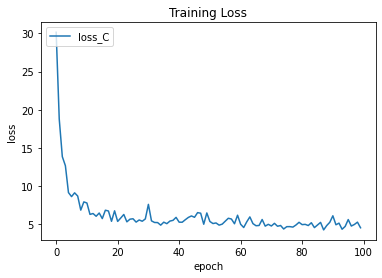

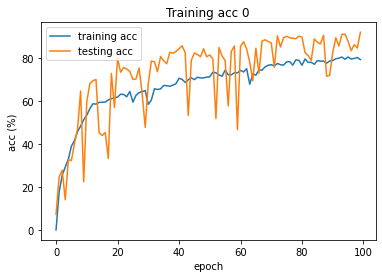

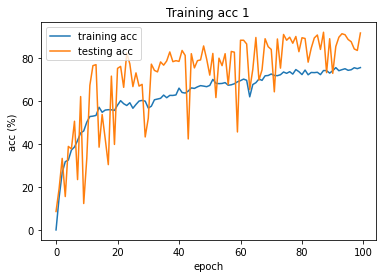

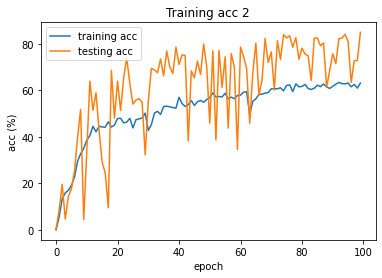

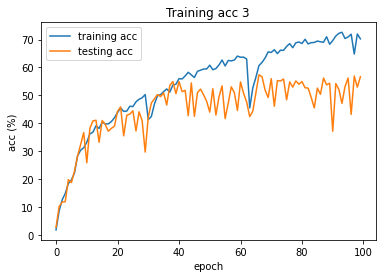

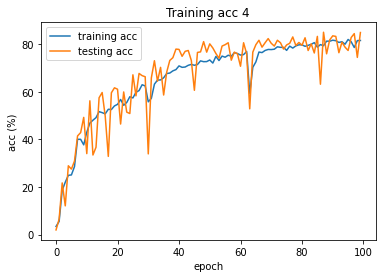

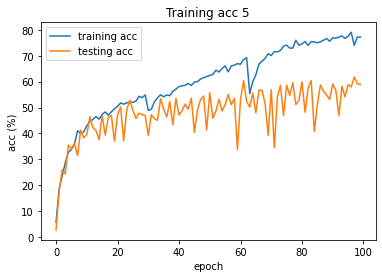

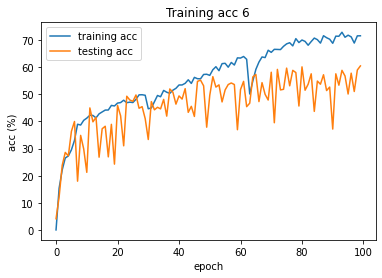

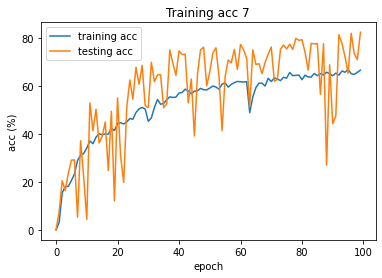

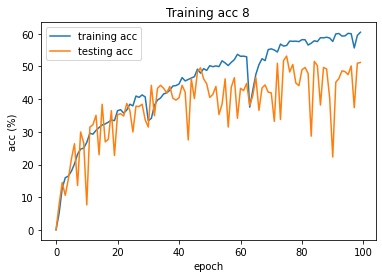

In [34]:
plt.figure()

x=loss_epoch_C # plot your loss
plt.plot(x)
plt.title('Training Loss')
plt.ylabel('loss'), plt.xlabel('epoch')
plt.legend(['loss_C'], loc = 'upper left')
#plt.savefig("resnext50-pretrained-loss.png")
plt.show()

for i in range( min(len(train_acc),len(test_acc)) ):
    plt.figure()
    x1 = train_acc[i]
    x2 = test_acc[i]
    plt.plot(x1)
    plt.plot(x2)
    plt.title('Training acc %d' %i )
    plt.ylabel('acc (%)'), plt.xlabel('epoch')
    plt.legend(['training acc', 'testing acc'], loc = 'upper left')
    #plt.savefig(store_name + "acc_top.png")
    plt.show()

### test the model

In [32]:

#load the model
model = PytorchModule().to(device)
model.load_state_dict(torch.load("mobilenet_RMSELoss50.ph"))
model.eval()

#Load the data
data = np.load("../dataset/lmks_CAT_06.npy",allow_pickle=True)
images = data.item().get("imgs")
imgs = []
for image in images:
    #plt.imshow(image)
    image = image[...,::-1].copy()
    imgs.append(image)
    #plt.imshow(image)

Using cache found in C:\Users\kaoti/.cache\torch\hub\pytorch_vision_v0.6.0


In [33]:
# test the data, because the model need input data number same as batch_size,
# so we will test batch_size's number of picture in a iteration.

# get the dataloader for cat06 test, the cat06 is not in any train or test data
def outside_test():
    data = np.load("../dataset/lmks_CAT_06.npy",allow_pickle=True)
    imgs = data.item().get("imgs")
    lmks = data.item().get("lmks")
    test_inputs = imgs
    test_labels = lmks
    test_dataloader = DataLoader(CatDataset(test_inputs,test_labels,test_transformer),
                                 batch_size = 32, shuffle = False)
    return test_dataloader
test_dataloader = outside_test()



total_test = 0
corrects_test = []
for i in range(9):
    corrects_test.append(0)
for i, (x, label) in enumerate(test_dataloader) :
        with torch.no_grad(): # 測試階段不需要求梯度
            x, label = x.to(device), label.to(device)
            output = model(x) # 將測試資料輸入至模型進行測試
            #loss = criterion(output, label.long()) # 計算測試資料的準確度
            predicted = output.data
            total_test += len(label)
            for j in range(len(predicted)):
                for k in range(len(corrects_test)):
                    if(distence(predicted[j][k*2],predicted[j][k*2+1],label[j][k*2],label[j][k*2+1]) < radius2):
                        corrects_test[k] += 1
                 #draw the picture with dot
#                 plt.figure()
#                 for k in range(len(corrects_test)):
#                     #valid positoin, greens
#                     plt.scatter(x = label.cpu()[j][k*2], y = label.cpu()[j][k*2+1], s = 7, color = "#40FF1E")
#                     #predicted position, orange point
#                     plt.scatter(x = predicted.cpu()[j][k*2], y = predicted.cpu()[j][k*2+1], s = 7, color = "#FF6C1E")
#                 plt.title("%d"%(i+j))
#                 plt.imshow(imgs[i+j])
#         break
for i in range(len(corrects_test)):
    print("acc %d : %.3f" %(i,corrects_test[i]/total_test))
for i in range(len(corrects_test)):
    print(" %.3f |" %(corrects_test[i]/total_test),end = "")

acc 0 : 0.809
acc 1 : 0.731
acc 2 : 0.768
acc 3 : 0.512
acc 4 : 0.795
acc 5 : 0.584
acc 6 : 0.479
acc 7 : 0.567
acc 8 : 0.444
 0.809 | 0.731 | 0.768 | 0.512 | 0.795 | 0.584 | 0.479 | 0.567 | 0.444 |

### the accuracy of the picture, the dataset is from Cat_06  
    if the predict point is 6 pixel near with the correct point then it counts


|name| loss function| epoch | acc0 | acc1 | acc2 | acc3 | acc4 | acc5 | acc6 | acc7 | acc8 |
|----|--------------|-------|------|------|------|------|------|------|------|------|------|
|mobilenet_RMSELoss100_36|RMSE|100| 0.910 | 0.915 | 0.865 | 0.468 | 0.852 | 0.610 | 0.604 | 0.840 | 0.443 |
|mobilenet_RMSELoss50|RMSE|50| 0.809 | 0.731 | 0.768 | 0.512 | 0.795 | 0.584 | 0.479 | 0.567 | 0.444 |